# # Бінарна класифікація з використанням логістичної регресії
# 
# **Мета:** Побудувати модель бінарної класифікації з нуля
# 
# **Модель:** Логістична регресія з реалізацією SGD та Mini-batch градієнтного спуску

In [1]:
# ## 1. Імпорт бібліотек

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Налаштування візуалізації
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")





In [2]:
# ## 2. Завантаження та аналіз даних

# Завантаження даних
df = pd.read_csv('synthetic_coffee_health_10000.csv')  # ⚠️ ЗАМІНІТЬ на назву вашого файлу

print("Розмір датасету:", df.shape)
print("\nПерші рядки:")
print(df.head())
print("\nІнформація про датасет:")
print(df.info())
print("\nНазви стовпців:")
print(df.columns.tolist())

# %%
# Перевірка пропущених значень
print("\nПропущені значення:")
print(df.isnull().sum())

Розмір датасету: (10000, 16)

Перші рядки:
   ID  Age  Gender  Country  Coffee_Intake  Caffeine_mg  Sleep_Hours  \
0   1   40    Male  Germany            3.5        328.1          7.5   
1   2   33    Male  Germany            1.0         94.1          6.2   
2   3   42    Male   Brazil            5.3        503.7          5.9   
3   4   53    Male  Germany            2.6        249.2          7.3   
4   5   32  Female    Spain            3.1        298.0          5.3   

  Sleep_Quality   BMI  Heart_Rate Stress_Level  Physical_Activity_Hours  \
0          Good  24.9          78          Low                     14.5   
1          Good  20.0          67          Low                     11.0   
2          Fair  22.7          59       Medium                     11.2   
3          Good  24.7          71          Low                      6.6   
4          Fair  24.1          76       Medium                      8.5   

  Health_Issues Occupation  Smoking  Alcohol_Consumption  
0           Na

✅ Використано 'Health_Issues' як цільову змінну (1 = без проблем)

Розподіл цільової змінної:
Target
1    5941
0    4059
Name: count, dtype: int64

Відсоткове співвідношення:
Target
1    59.41
0    40.59
Name: proportion, dtype: float64
Видалено стовпці: ['ID']

Стовпці після очищення:
['Age', 'Gender', 'Country', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'Sleep_Quality', 'BMI', 'Heart_Rate', 'Stress_Level', 'Physical_Activity_Hours', 'Health_Issues', 'Occupation', 'Smoking', 'Alcohol_Consumption', 'Target']


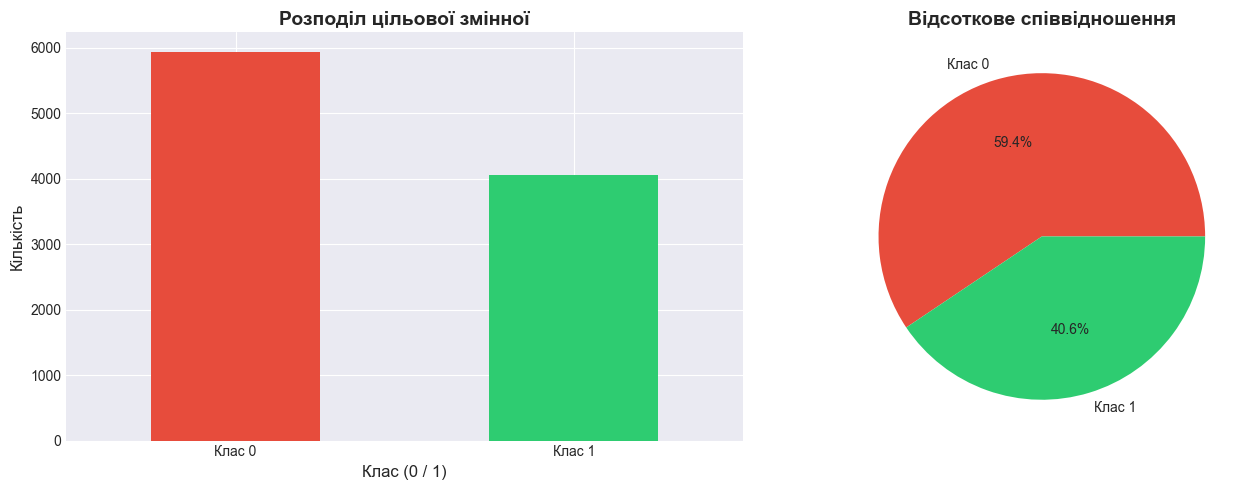

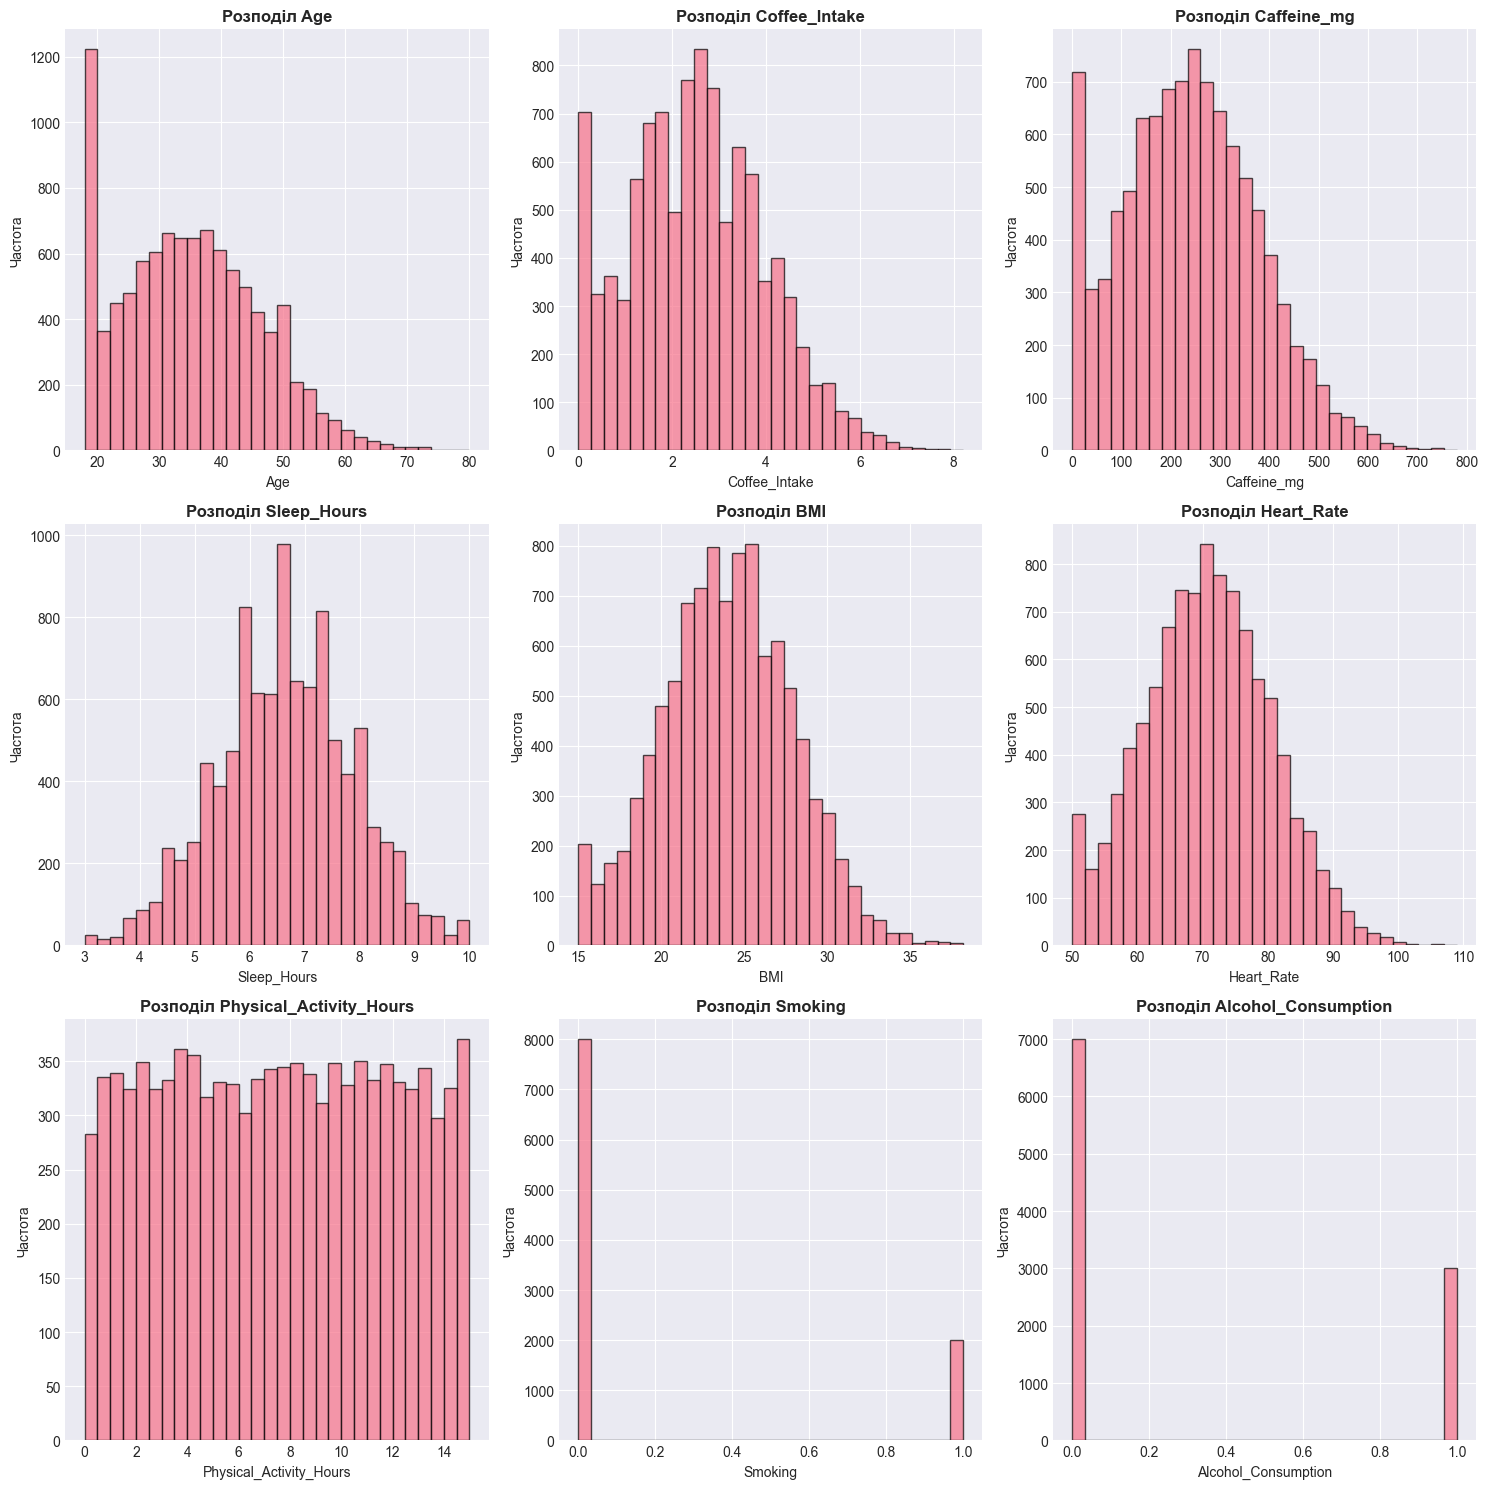


Статистика числових ознак:
                Age  Coffee_Intake   Caffeine_mg   Sleep_Hours           BMI  \
count  10000.000000   10000.000000  10000.000000  10000.000000  10000.000000   
mean      34.949100       2.509230    238.411010      6.636220     23.986860   
std       11.160939       1.450248    137.748815      1.222055      3.906411   
min       18.000000       0.000000      0.000000      3.000000     15.000000   
25%       26.000000       1.500000    138.750000      5.800000     21.300000   
50%       34.000000       2.500000    235.400000      6.600000     24.000000   
75%       43.000000       3.500000    332.025000      7.500000     26.600000   
max       80.000000       8.200000    780.300000     10.000000     38.200000   

         Heart_Rate  Physical_Activity_Hours      Smoking  Alcohol_Consumption  
count  10000.000000              10000.00000  10000.00000         10000.000000  
mean      70.617800                  7.48704      0.20040             0.300700  
std     

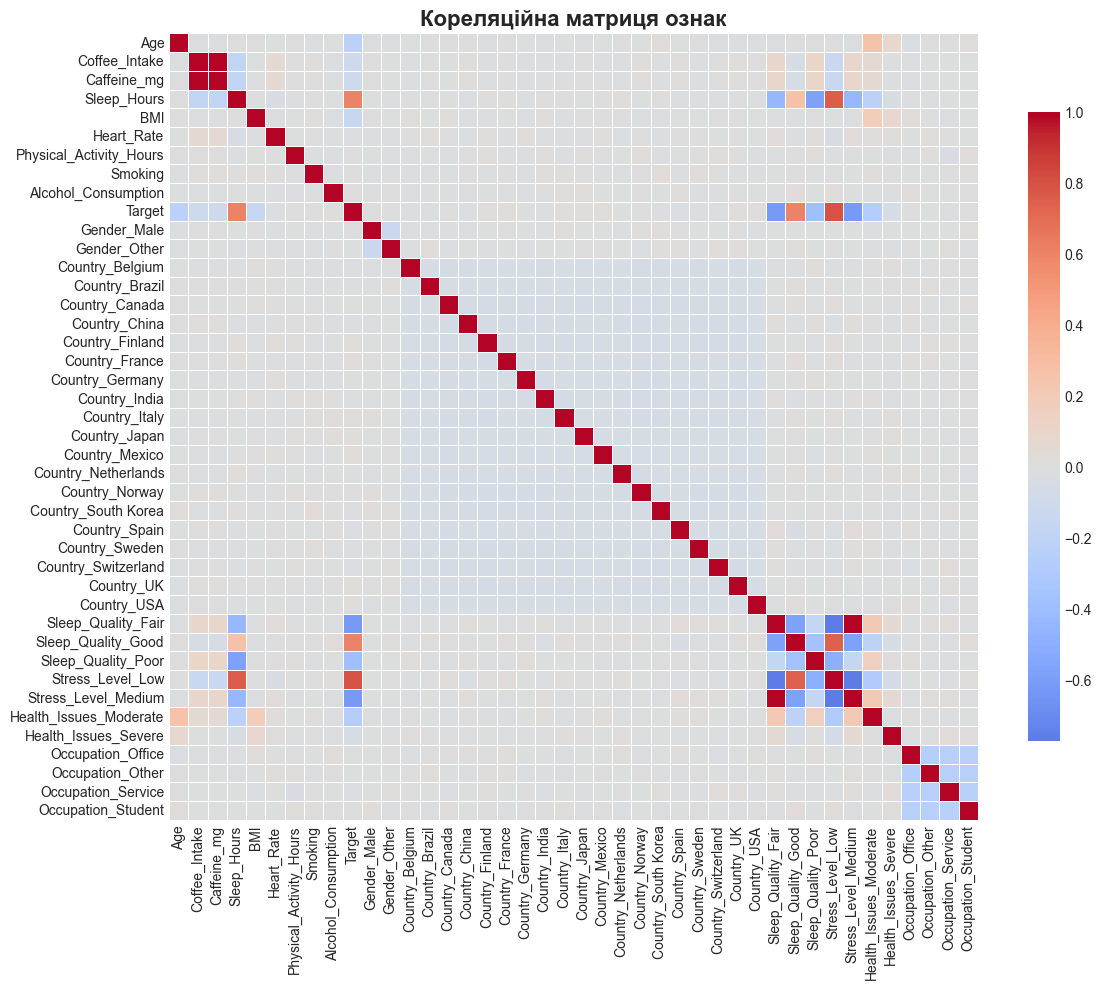


Топ-15 ознак за кореляцією з цільовою змінною:
Target                 1.000000
Stress_Level_Low       0.794087
Sleep_Quality_Good     0.600356
Sleep_Hours            0.600190
Country_France         0.022020
Country_Italy          0.020015
Country_Mexico         0.018094
Country_UK             0.011624
Country_USA            0.010674
Alcohol_Consumption    0.010454
Country_Finland        0.010190
Country_Japan          0.009985
Occupation_Student     0.009123
Country_Norway         0.008494
Country_Canada         0.008451
Smoking                0.007846
Name: Target, dtype: float64


In [3]:
# ## 3. Створення цільової змінної

# Автоматичний вибір: спробуємо знайти підходящий стовпець
if 'Test Results' in df.columns:
    df['Target'] = (df['Test Results'] == 'Normal').astype(int)
    print("✅ Використано 'Test Results' як цільову змінну")
elif 'Health_Issues' in df.columns:
    # Якщо є інформація про проблеми зі здоров'ям
    df['Target'] = (df['Health_Issues'].isna() | (df['Health_Issues'] == 'None')).astype(int)
    print("✅ Використано 'Health_Issues' як цільову змінну (1 = без проблем)")
elif 'Sleep_Quality' in df.columns:
    # На основі якості сну
    median_quality = df['Sleep_Quality'].median()
    df['Target'] = (df['Sleep_Quality'] >= median_quality).astype(int)
    print(f"✅ Створено цільову змінну на основі 'Sleep_Quality' (поріг: {median_quality})")
else:
    # Якщо нічого не підійшло, використовуємо перший бінарний стовпець
    for col in df.columns:
        if df[col].nunique() == 2:
            unique_vals = df[col].unique()
            df['Target'] = (df[col] == unique_vals[0]).astype(int)
            print(f"✅ Використано '{col}' як цільову змінну")
            break

# Перевірка цільової змінної
if 'Target' in df.columns:
    print("\nРозподіл цільової змінної:")
    print(df['Target'].value_counts())
    print("\nВідсоткове співвідношення:")
    print(df['Target'].value_counts(normalize=True) * 100)
else:
    print("❌ ПОМИЛКА: Не вдалося створити цільову змінну. Створіть її вручну.")

# %%
# Видалення непотрібних стовпців
# ⚠️ АДАПТУЙТЕ під ваші дані
columns_to_drop = []

# Стандартні стовпці для видалення (якщо є)
potential_drops = ['ID', 'Name', 'Date', 'Date of Admission', 'Doctor', 'Hospital', 
                   'Room Number', 'Discharge Date', 'Test Results']

for col in potential_drops:
    if col in df.columns:
        columns_to_drop.append(col)

# Видаляємо колонки
if columns_to_drop:
    df_clean = df.drop(columns=columns_to_drop)
    print(f"Видалено стовпці: {columns_to_drop}")
else:
    df_clean = df.copy()
    print("Стовпці для видалення не знайдено")

print("\nСтовпці після очищення:")
print(df_clean.columns.tolist())

# ## 4. Аналіз даних
# 
# ### 4.1 Візуалізація розподілу цільової змінної
if 'Target' in df_clean.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Графік 1: Стовпчаста діаграма
    df_clean['Target'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
    axes[0].set_title('Розподіл цільової змінної', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Клас (0 / 1)', fontsize=12)
    axes[0].set_ylabel('Кількість', fontsize=12)
    axes[0].set_xticklabels(['Клас 0', 'Клас 1'], rotation=0)
    
    # Графік 2: Кругова діаграма
    df_clean['Target'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%',
                                           colors=['#e74c3c', '#2ecc71'],
                                           labels=['Клас 0', 'Клас 1'])
    axes[1].set_title('Відсоткове співвідношення', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.show()

# ### 4.2 Аналіз числових ознак

# Візуалізація розподілу числових ознак
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'Target' in numeric_cols:
    numeric_cols.remove('Target')

if numeric_cols:
    n_cols = len(numeric_cols)
    n_rows = (n_cols + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].hist(df_clean[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_title(f'Розподіл {col}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel(col, fontsize=10)
        axes[idx].set_ylabel('Частота', fontsize=10)
    
    # Сховати зайві осі
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Статистика числових ознак
print("\nСтатистика числових ознак:")
print(df_clean[numeric_cols].describe())


# ### 4.3 Кореляційна матриця

# One-hot encoding для побудови кореляційної матриці
df_encoded_temp = pd.get_dummies(df_clean, drop_first=True)

# Кореляційна матриця
correlation_matrix = df_encoded_temp.corr()

# Візуалізація
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Кореляційна матриця ознак', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Топ кореляцій з цільовою змінною
if 'Target' in correlation_matrix.columns:
    target_corr = correlation_matrix['Target'].sort_values(ascending=False)
    print("\nТоп-15 ознак за кореляцією з цільовою змінною:")
    print(target_corr.head(16))  # 16, бо перша - сама цільова змінна


In [4]:
# ## 5. Підготовка даних для моделі
# ### 5.1 Відокремлення цільової змінної та ознак

# Відокремлення цільової змінної
if 'Target' not in df_clean.columns:
    raise ValueError("❌ Цільова змінна 'Target' не знайдена! Створіть її у попередніх кроках.")

y = df_clean['Target'].values
X = df_clean.drop('Target', axis=1)

print(f"Кількість прикладів: {len(y)}")
print(f"Кількість ознак (до кодування): {X.shape[1]}")
print(f"Розподіл класів: {np.bincount(y)}")

# ### 5.2 One-hot encoding категоріальних ознак

# Визначення категоріальних стовпців
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Категоріальні стовпці для кодування: {categorical_cols}")

# One-hot encoding
if categorical_cols:
    X_encoded = pd.get_dummies(X, drop_first=True)
    print(f"Кількість ознак після one-hot encoding: {X_encoded.shape[1]}")
else:
    X_encoded = X.copy()
    print("Категоріальних стовпців не знайдено")

print(f"\nВсі ознаки після кодування:")
print(X_encoded.columns.tolist())

# ### 5.3 Нормалізація числових ознак

# Нормалізація (стандартизація)
def normalize_features(X):
    """Z-score нормалізація"""
    # Конвертуємо в numpy array та переконуємося що це float64
    if isinstance(X, pd.DataFrame):
        X = X.values
    X = np.array(X, dtype=np.float64)
    
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    
    # Уникнення ділення на нуль
    std = np.where(std == 0, 1, std)
    
    X_normalized = (X - mean) / std
    
    return X_normalized, mean, std

# Переконуємося, що X_encoded містить лише числові дані
X_encoded = X_encoded.apply(pd.to_numeric, errors='coerce')
X_encoded = X_encoded.fillna(0)  # Заповнюємо NaN нулями

X_normalized, X_mean, X_std = normalize_features(X_encoded)
print("✅ Дані нормалізовано")
print(f"Форма X: {X_normalized.shape}")
print(f"Форма y: {y.shape}")

# ### 5.4 Розділення на тренувальний, валідаційний та тестовий набори

# Спочатку розділимо на train (60%) та temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_normalized, y, test_size=0.4, random_state=42, stratify=y
)

# Потім temp розділимо на validation (20%) та test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Розмір тренувального набору: {X_train.shape}")
print(f"Розмір валідаційного набору: {X_val.shape}")
print(f"Розмір тестового набору: {X_test.shape}")

# Розподіл класів
print(f"\nТренувальний набір - Клас 1: {np.sum(y_train)} ({np.mean(y_train)*100:.1f}%)")
print(f"Валідаційний набір - Клас 1: {np.sum(y_val)} ({np.mean(y_val)*100:.1f}%)")
print(f"Тестовий набір - Клас 1: {np.sum(y_test)} ({np.mean(y_test)*100:.1f}%)")


Кількість прикладів: 10000
Кількість ознак (до кодування): 15
Розподіл класів: [4059 5941]
Категоріальні стовпці для кодування: ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Health_Issues', 'Occupation']
Кількість ознак після one-hot encoding: 41

Всі ознаки після кодування:
['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours', 'Smoking', 'Alcohol_Consumption', 'Gender_Male', 'Gender_Other', 'Country_Belgium', 'Country_Brazil', 'Country_Canada', 'Country_China', 'Country_Finland', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Japan', 'Country_Mexico', 'Country_Netherlands', 'Country_Norway', 'Country_South Korea', 'Country_Spain', 'Country_Sweden', 'Country_Switzerland', 'Country_UK', 'Country_USA', 'Sleep_Quality_Fair', 'Sleep_Quality_Good', 'Sleep_Quality_Poor', 'Stress_Level_Low', 'Stress_Level_Medium', 'Health_Issues_Moderate', 'Health_Issues_Severe', 'Occupation_Office', 'Occupation_Other'

In [5]:
# ## 6. Реалізація логістичної регресії
# ### 6.1 Основні функції

def sigmoid(z):
    """
    Сигмоїдна функція активації
    σ(z) = 1 / (1 + e^(-z))
    """
    # Обмеження для уникнення overflow
    z = np.clip(z, -500, 500)
    return 1 / (1 + np.exp(-z))

def compute_loss(X, y, weights, lambda_l1=0, lambda_l2=0):
    """
    Обчислення Log Loss (Binary Cross-Entropy) з регуляризацією
    
    L = -1/m * Σ[y*log(ŷ) + (1-y)*log(1-ŷ)] + регуляризація
    """
    m = len(y)
    predictions = sigmoid(np.dot(X, weights))
    
    # Уникнення log(0)
    epsilon = 1e-15
    predictions = np.clip(predictions, epsilon, 1 - epsilon)
    
    # Основна функція втрат
    loss = -np.mean(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
    
    # Додавання регуляризації (не застосовуємо до intercept - перша вага)
    if lambda_l2 > 0:
        loss += (lambda_l2 / (2 * m)) * np.sum(weights[1:]**2)
    if lambda_l1 > 0:
        loss += (lambda_l1 / m) * np.sum(np.abs(weights[1:]))
    
    return loss

def compute_gradient(X, y, weights, lambda_l1=0, lambda_l2=0):
    """
    Обчислення градієнта функції втрат
    
    ∂L/∂w = 1/m * X^T * (ŷ - y) + регуляризація
    """
    m = len(y)
    predictions = sigmoid(np.dot(X, weights))
    gradient = np.dot(X.T, (predictions - y)) / m
    
    # Додавання регуляризації (не застосовуємо до intercept)
    if lambda_l2 > 0:
        gradient[1:] += (lambda_l2 / m) * weights[1:]
    if lambda_l1 > 0:
        gradient[1:] += (lambda_l1 / m) * np.sign(weights[1:])
    
    return gradient

def initialize_weights(n_features):
    """Ініціалізація ваг малими випадковими значеннями"""
    return np.random.randn(n_features) * 0.01

# ### 6.2 Стохастичний градієнтний спуск (SGD)

# %%
def sgd(X, y, X_val, y_val, learning_rate=0.01, max_epochs=100, 
        lambda_l1=0, lambda_l2=0, patience=10, verbose=True):
    """
    Стохастичний градієнтний спуск
    Оновлення ваг після кожного прикладу
    """
    n_features = X.shape[1]
    weights = initialize_weights(n_features)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_weights = None
    best_epoch = 0
    epochs_no_improve = 0
    
    for epoch in range(max_epochs):
        # Перемішування даних на кожній епосі
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Оновлення ваг для кожного прикладу
        for i in range(len(X)):
            X_i = X_shuffled[i:i+1]
            y_i = y_shuffled[i:i+1]
            
            gradient = compute_gradient(X_i, y_i, weights, lambda_l1, lambda_l2)
            weights -= learning_rate * gradient
        
        # Обчислення втрат після епохи
        train_loss = compute_loss(X, y, weights, lambda_l1, lambda_l2)
        val_loss = compute_loss(X_val, y_val, weights, lambda_l1, lambda_l2)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = weights.copy()
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            if verbose:
                print(f"Early stopping на епосі {epoch}")
            break
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Епоха {epoch+1}/{max_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if verbose:
        print(f"\nНайкраща модель на епосі {best_epoch} з Val Loss: {best_val_loss:.4f}")
    
    return best_weights, train_losses, val_losses, best_epoch

# ### 6.3 Mini-batch градієнтний спуск

def mini_batch_gd(X, y, X_val, y_val, learning_rate=0.01, batch_size=32, 
                  max_epochs=100, lambda_l1=0, lambda_l2=0, patience=10, verbose=True):
    """
    Mini-batch градієнтний спуск
    Оновлення ваг після кожного батчу
    """
    n_features = X.shape[1]
    weights = initialize_weights(n_features)
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_weights = None
    best_epoch = 0
    epochs_no_improve = 0
    
    for epoch in range(max_epochs):
        # Перемішування даних
        indices = np.random.permutation(len(X))
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        # Оновлення ваг для кожного батчу
        for i in range(0, len(X), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            gradient = compute_gradient(X_batch, y_batch, weights, lambda_l1, lambda_l2)
            weights -= learning_rate * gradient
        
        # Обчислення втрат після епохи
        train_loss = compute_loss(X, y, weights, lambda_l1, lambda_l2)
        val_loss = compute_loss(X_val, y_val, weights, lambda_l1, lambda_l2)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_weights = weights.copy()
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            if verbose:
                print(f"Early stopping на епосі {epoch}")
            break
        
        if verbose and (epoch + 1) % 10 == 0:
            print(f"Епоха {epoch+1}/{max_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    if verbose:
        print(f"\nНайкраща модель на епосі {best_epoch} з Val Loss: {best_val_loss:.4f}")
    
    return best_weights, train_losses, val_losses, best_epoch

# ### 6.4 Функції для прогнозування

def predict(X, weights, threshold=0.5):
    """Прогнозування класів"""
    probabilities = sigmoid(np.dot(X, weights))
    return (probabilities >= threshold).astype(int)

def predict_proba(X, weights):
    """Прогнозування ймовірностей"""
    return sigmoid(np.dot(X, weights))


In [6]:
# ## 7. Навчання моделей
# ### 7.1 Додавання intercept

# Додавання intercept (стовпець одиниць)
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
X_val_with_intercept = np.c_[np.ones(X_val.shape[0]), X_val]
X_test_with_intercept = np.c_[np.ones(X_test.shape[0]), X_test]

print(f"Форма X_train з intercept: {X_train_with_intercept.shape}")

# ### 7.2 Навчання: Стохастичний градієнтний спуск

print("=" * 60)
print("НАВЧАННЯ: Стохастичний градієнтний спуск (SGD)")
print("=" * 60)

weights_sgd, train_losses_sgd, val_losses_sgd, best_epoch_sgd = sgd(
    X_train_with_intercept, y_train, X_val_with_intercept, y_val,
    learning_rate=0.1,
    max_epochs=200,
    patience=15,
    verbose=True
)

# ### 7.3 Навчання: Mini-batch градієнтний спуск

print("\n" + "=" * 60)
print("НАВЧАННЯ: Mini-batch градієнтний спуск")
print("=" * 60)

weights_mb, train_losses_mb, val_losses_mb, best_epoch_mb = mini_batch_gd(
    X_train_with_intercept, y_train, X_val_with_intercept, y_val,
    learning_rate=0.1,
    batch_size=32,
    max_epochs=200,
    patience=15,
    verbose=True
)


Форма X_train з intercept: (6000, 42)
НАВЧАННЯ: Стохастичний градієнтний спуск (SGD)
Епоха 10/200 - Train Loss: 0.2485, Val Loss: 0.2703
Епоха 20/200 - Train Loss: 0.2292, Val Loss: 0.2448
Епоха 30/200 - Train Loss: 0.2379, Val Loss: 0.2500
Early stopping на епосі 31

Найкраща модель на епосі 16 з Val Loss: 0.2108

НАВЧАННЯ: Mini-batch градієнтний спуск
Епоха 10/200 - Train Loss: 0.1673, Val Loss: 0.1810
Епоха 20/200 - Train Loss: 0.1651, Val Loss: 0.1789
Епоха 30/200 - Train Loss: 0.1643, Val Loss: 0.1780
Епоха 40/200 - Train Loss: 0.1639, Val Loss: 0.1769
Епоха 50/200 - Train Loss: 0.1638, Val Loss: 0.1758
Епоха 60/200 - Train Loss: 0.1637, Val Loss: 0.1766
Early stopping на епосі 64

Найкраща модель на епосі 49 з Val Loss: 0.1758


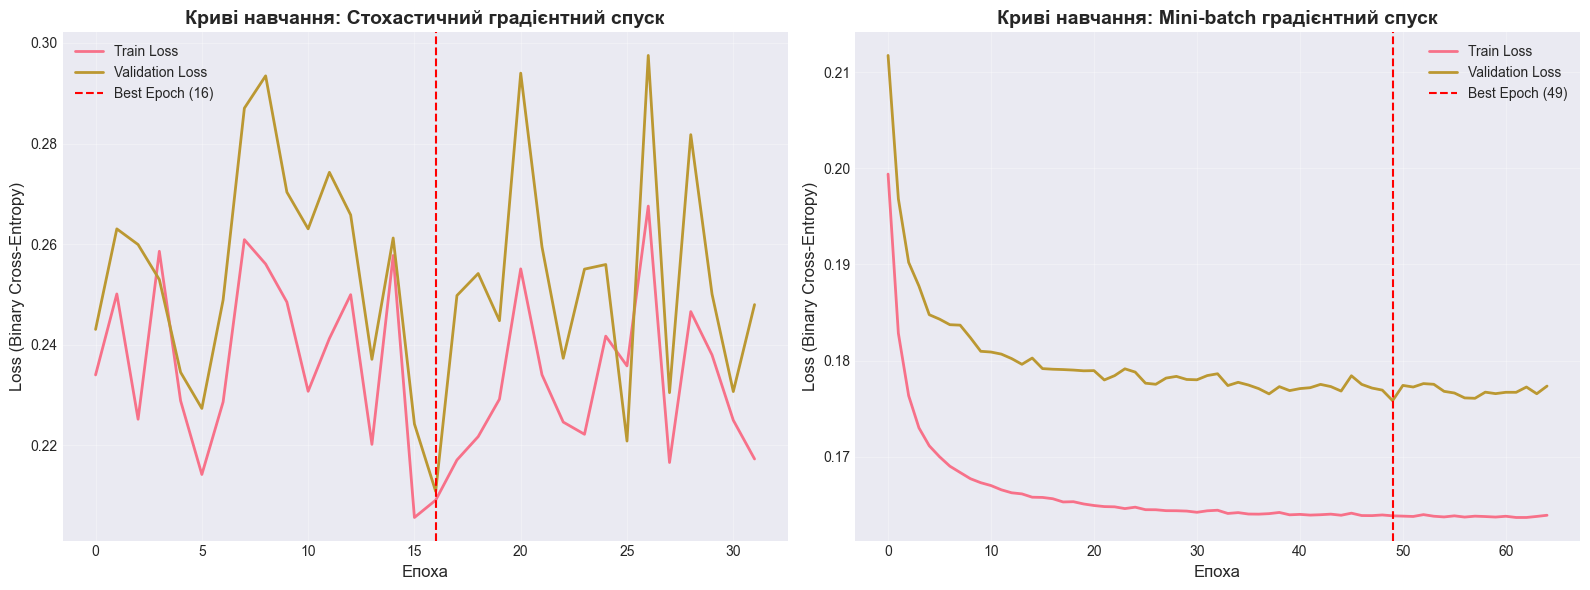

In [7]:
# ## 8. Візуалізація кривих навчання

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SGD
axes[0].plot(train_losses_sgd, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_sgd, label='Validation Loss', linewidth=2)
axes[0].axvline(x=best_epoch_sgd, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_sgd})')
axes[0].set_xlabel('Епоха', fontsize=12)
axes[0].set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
axes[0].set_title('Криві навчання: Стохастичний градієнтний спуск', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Mini-batch
axes[1].plot(train_losses_mb, label='Train Loss', linewidth=2)
axes[1].plot(val_losses_mb, label='Validation Loss', linewidth=2)
axes[1].axvline(x=best_epoch_mb, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_mb})')
axes[1].set_xlabel('Епоха', fontsize=12)
axes[1].set_ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
axes[1].set_title('Криві навчання: Mini-batch градієнтний спуск', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



In [8]:
# ## 9. Оцінка моделей на тестовому наборі

def evaluate_model(X, y, weights, model_name):
    """Оцінка моделі та виведення метрик"""
    y_pred = predict(X, weights)
    
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)
    cm = confusion_matrix(y, y_pred)
    
    print(f"\n{'='*60}")
    print(f"ОЦІНКА МОДЕЛІ: {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    
    return {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Оцінка обох моделей
results_sgd = evaluate_model(X_test_with_intercept, y_test, weights_sgd, "SGD")
results_mb = evaluate_model(X_test_with_intercept, y_test, weights_mb, "Mini-batch GD")



ОЦІНКА МОДЕЛІ: SGD
Accuracy:  0.9245 (92.45%)
Precision: 0.9303
Recall:    0.9436
F1-Score:  0.9369

ОЦІНКА МОДЕЛІ: Mini-batch GD
Accuracy:  0.9415 (94.15%)
Precision: 0.9357
Recall:    0.9680
F1-Score:  0.9516


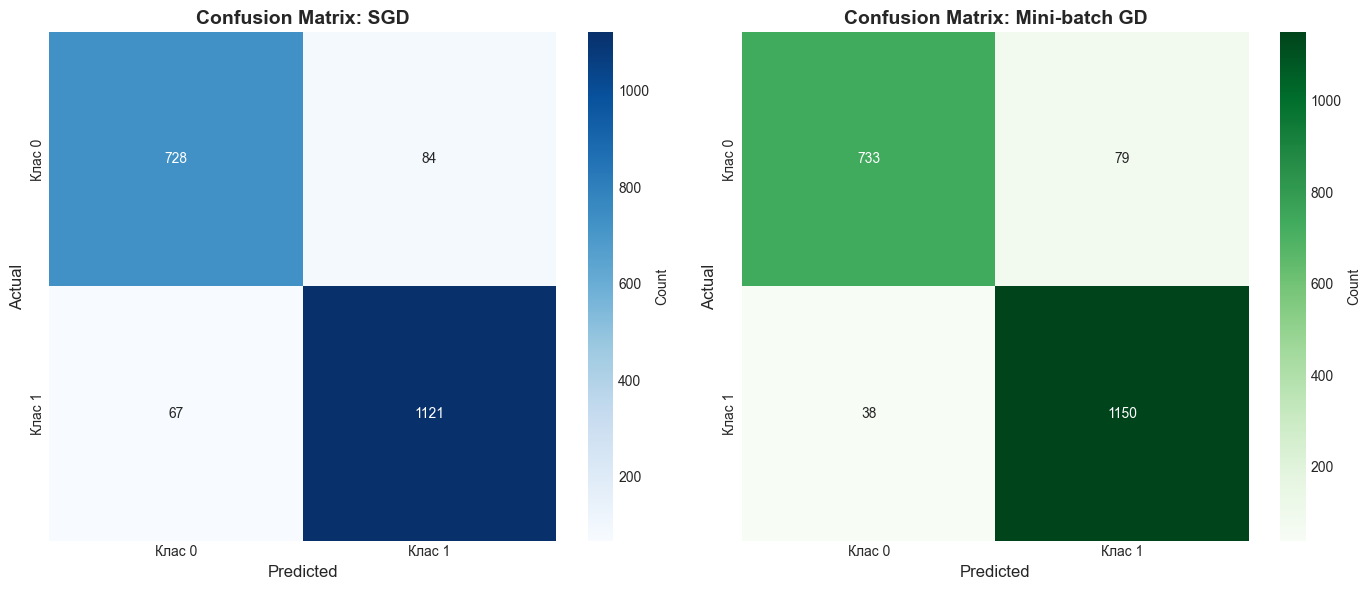

In [9]:
# ## 10. Confusion Matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# SGD
sns.heatmap(results_sgd['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix: SGD', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_xticklabels(['Клас 0', 'Клас 1'])
axes[0].set_yticklabels(['Клас 0', 'Клас 1'])

# Mini-batch
sns.heatmap(results_mb['confusion_matrix'], annot=True, fmt='d', cmap='Greens', 
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix: Mini-batch GD', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_xticklabels(['Клас 0', 'Клас 1'])
axes[1].set_yticklabels(['Клас 0', 'Клас 1'])

plt.tight_layout()
plt.show()


In [10]:
# ## 11. Порівняльна таблиця метрик

comparison_df = pd.DataFrame([
    {
        'Метод': 'SGD',
        'Accuracy': f"{results_sgd['accuracy']:.4f}",
        'Precision': f"{results_sgd['precision']:.4f}",
        'Recall': f"{results_sgd['recall']:.4f}",
        'F1-Score': f"{results_sgd['f1']:.4f}",
        'Епох': len(train_losses_sgd)
    },
    {
        'Метод': 'Mini-batch GD',
        'Accuracy': f"{results_mb['accuracy']:.4f}",
        'Precision': f"{results_mb['precision']:.4f}",
        'Recall': f"{results_mb['recall']:.4f}",
        'F1-Score': f"{results_mb['f1']:.4f}",
        'Епох': len(train_losses_mb)
    }
])

print("\n" + "="*80)
print("ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК")
print("="*80)
print(comparison_df.to_string(index=False))



ПОРІВНЯЛЬНА ТАБЛИЦЯ МЕТРИК
        Метод Accuracy Precision Recall F1-Score  Епох
          SGD   0.9245    0.9303 0.9436   0.9369    32
Mini-batch GD   0.9415    0.9357 0.9680   0.9516    65



НАВЧАННЯ З L2 РЕГУЛЯРИЗАЦІЄЮ (Ridge)
Епоха 10/200 - Train Loss: 0.1677, Val Loss: 0.1814
Епоха 20/200 - Train Loss: 0.1655, Val Loss: 0.1790
Епоха 30/200 - Train Loss: 0.1647, Val Loss: 0.1778
Епоха 40/200 - Train Loss: 0.1645, Val Loss: 0.1774
Епоха 50/200 - Train Loss: 0.1641, Val Loss: 0.1768
Епоха 60/200 - Train Loss: 0.1642, Val Loss: 0.1786
Епоха 70/200 - Train Loss: 0.1640, Val Loss: 0.1770
Early stopping на епосі 70

Найкраща модель на епосі 55 з Val Loss: 0.1762

ОЦІНКА МОДЕЛІ: Mini-batch GD + L2
Accuracy:  0.9405 (94.05%)
Precision: 0.9342
Recall:    0.9680
F1-Score:  0.9508

НАВЧАННЯ З L1 РЕГУЛЯРИЗАЦІЄЮ (Lasso)
Епоха 10/200 - Train Loss: 0.1675, Val Loss: 0.1809
Епоха 20/200 - Train Loss: 0.1653, Val Loss: 0.1787
Епоха 30/200 - Train Loss: 0.1646, Val Loss: 0.1774
Епоха 40/200 - Train Loss: 0.1643, Val Loss: 0.1769
Епоха 50/200 - Train Loss: 0.1641, Val Loss: 0.1764
Епоха 60/200 - Train Loss: 0.1641, Val Loss: 0.1763
Early stopping на епосі 63

Найкраща модель на епосі 48 з

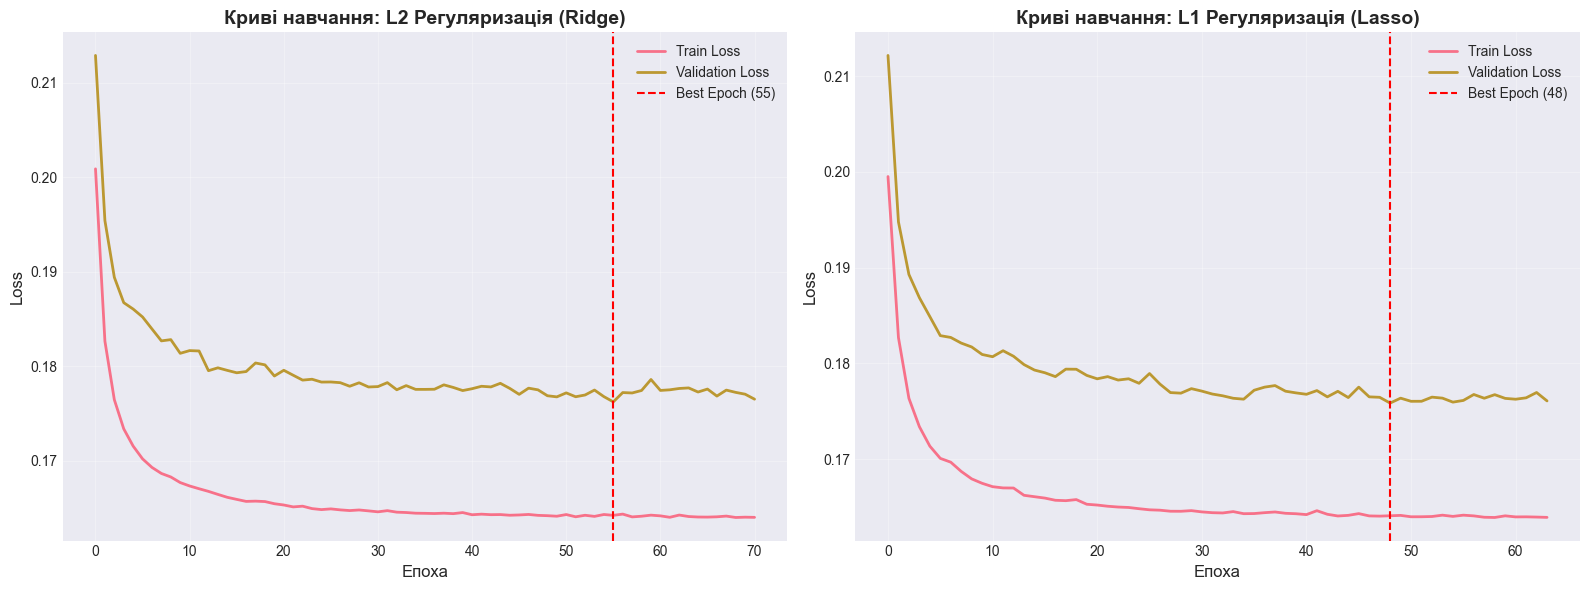


ПОВНА ПОРІВНЯЛЬНА ТАБЛИЦЯ ВСІХ МОДЕЛЕЙ
          Метод Accuracy Precision Recall F1-Score
            SGD   0.9245    0.9303 0.9436   0.9369
  Mini-batch GD   0.9415    0.9357 0.9680   0.9516
Mini-batch + L2   0.9405    0.9342 0.9680   0.9508
Mini-batch + L1   0.9400    0.9341 0.9672   0.9504


In [11]:
# ## 12. Додатково: Регуляризація L2 та L1

# ### 12.1 L2 Регуляризація (Ridge)


print("\n" + "="*60)
print("НАВЧАННЯ З L2 РЕГУЛЯРИЗАЦІЄЮ (Ridge)")
print("="*60)

weights_l2, train_losses_l2, val_losses_l2, best_epoch_l2 = mini_batch_gd(
    X_train_with_intercept, y_train, X_val_with_intercept, y_val,
    learning_rate=0.1,
    batch_size=32,
    max_epochs=200,
    lambda_l2=0.01,
    patience=15,
    verbose=True
)

results_l2 = evaluate_model(X_test_with_intercept, y_test, weights_l2, "Mini-batch GD + L2")

# ### 12.2 L1 Регуляризація (Lasso)

print("\n" + "="*60)
print("НАВЧАННЯ З L1 РЕГУЛЯРИЗАЦІЄЮ (Lasso)")
print("="*60)

weights_l1, train_losses_l1, val_losses_l1, best_epoch_l1 = mini_batch_gd(
    X_train_with_intercept, y_train, X_val_with_intercept, y_val,
    learning_rate=0.1,
    batch_size=32,
    max_epochs=200,
    lambda_l1=0.01,
    patience=15,
    verbose=True
)

results_l1 = evaluate_model(X_test_with_intercept, y_test, weights_l1, "Mini-batch GD + L1")

# ### 12.3 Візуалізація кривих для регуляризованих моделей

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# L2
axes[0].plot(train_losses_l2, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_l2, label='Validation Loss', linewidth=2)
axes[0].axvline(x=best_epoch_l2, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_l2})')
axes[0].set_xlabel('Епоха', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Криві навчання: L2 Регуляризація (Ridge)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# L1
axes[1].plot(train_losses_l1, label='Train Loss', linewidth=2)
axes[1].plot(val_losses_l1, label='Validation Loss', linewidth=2)
axes[1].axvline(x=best_epoch_l1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch_l1})')
axes[1].set_xlabel('Епоха', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Криві навчання: L1 Регуляризація (Lasso)', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ### 12.4 Повна порівняльна таблиця

comparison_full_df = pd.DataFrame([
    {
        'Метод': 'SGD',
        'Accuracy': f"{results_sgd['accuracy']:.4f}",
        'Precision': f"{results_sgd['precision']:.4f}",
        'Recall': f"{results_sgd['recall']:.4f}",
        'F1-Score': f"{results_sgd['f1']:.4f}"
    },
    {
        'Метод': 'Mini-batch GD',
        'Accuracy': f"{results_mb['accuracy']:.4f}",
        'Precision': f"{results_mb['precision']:.4f}",
        'Recall': f"{results_mb['recall']:.4f}",
        'F1-Score': f"{results_mb['f1']:.4f}"
    },
    {
        'Метод': 'Mini-batch + L2',
        'Accuracy': f"{results_l2['accuracy']:.4f}",
        'Precision': f"{results_l2['precision']:.4f}",
        'Recall': f"{results_l2['recall']:.4f}",
        'F1-Score': f"{results_l2['f1']:.4f}"
    },
    {
        'Метод': 'Mini-batch + L1',
        'Accuracy': f"{results_l1['accuracy']:.4f}",
        'Precision': f"{results_l1['precision']:.4f}",
        'Recall': f"{results_l1['recall']:.4f}",
        'F1-Score': f"{results_l1['f1']:.4f}"
    }
])

print("\n" + "="*80)
print("ПОВНА ПОРІВНЯЛЬНА ТАБЛИЦЯ ВСІХ МОДЕЛЕЙ")
print("="*80)
print(comparison_full_df.to_string(index=False))



АНАЛІЗ ПОМИЛКОВИХ КЛАСИФІКАЦІЙ

False Positives (передбачили 1, насправді 0): 79
False Negatives (передбачили 0, насправді 1): 38

Детальний розбір Confusion Matrix:
True Negatives (правильно передбачені 0):  733
False Positives (помилково передбачені 1): 79
False Negatives (помилково передбачені 0): 38
True Positives (правильно передбачені 1):  1150

Відсотки:
True Negative Rate:  36.65%
False Positive Rate: 3.95%
False Negative Rate: 1.90%
True Positive Rate:  57.50%


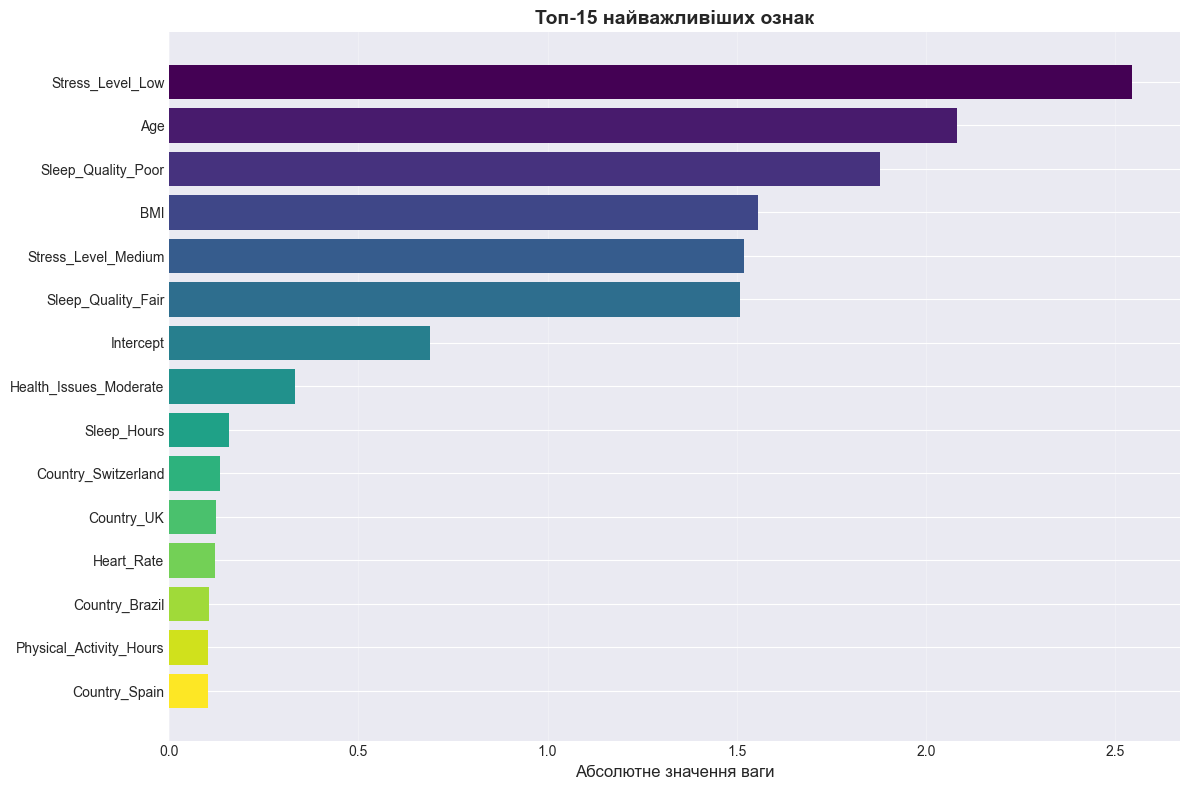


Найважливіші ознаки:
1. Stress_Level_Low: 2.5448
2. Age: 2.0833
3. Sleep_Quality_Poor: 1.8797
4. BMI: 1.5555
5. Stress_Level_Medium: 1.5204
6. Sleep_Quality_Fair: 1.5100
7. Intercept: 0.6884
8. Health_Issues_Moderate: 0.3330
9. Sleep_Hours: 0.1572
10. Country_Switzerland: 0.1334
11. Country_UK: 0.1231
12. Heart_Rate: 0.1197
13. Country_Brazil: 0.1040
14. Physical_Activity_Hours: 0.1027
15. Country_Spain: 0.1017


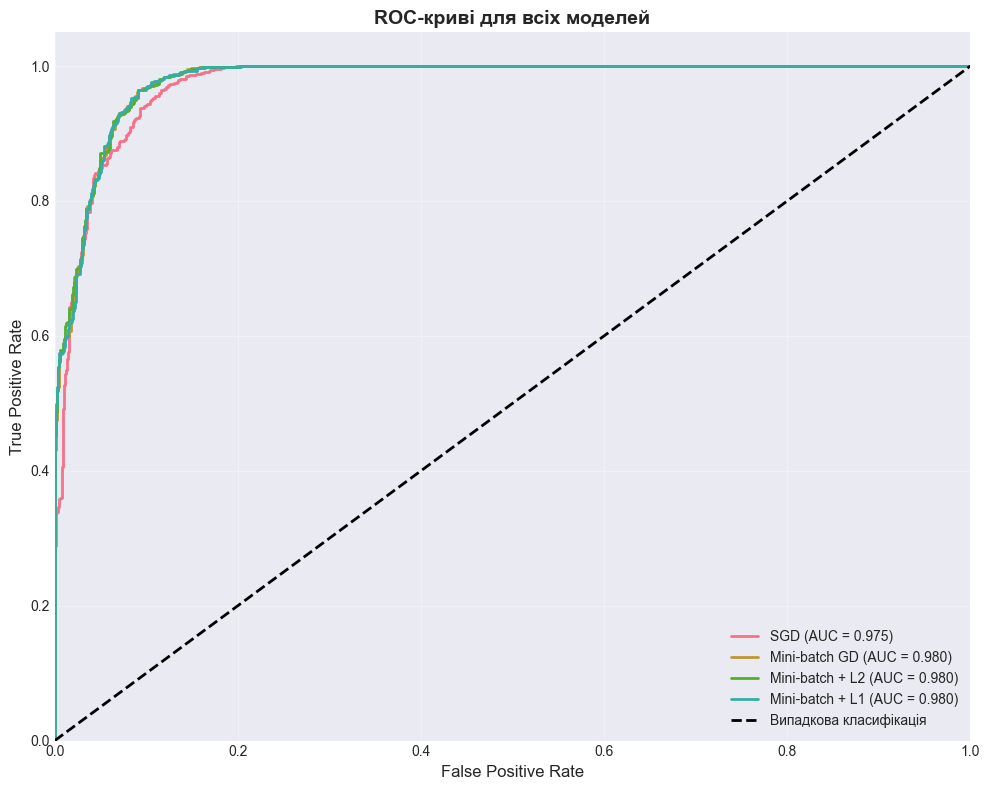


✅ Найкраща модель (Mini-batch GD) збережена у 'best_model_weights.npy'
   F1-Score: 0.9516
✅ Параметри нормалізації збережені


In [12]:
# ## 13. Аналіз помилкових класифікацій

# Детальний аналіз на основі найкращої моделі
y_pred_best = predict(X_test_with_intercept, weights_mb)

false_positives = np.where((y_test == 0) & (y_pred_best == 1))[0]
false_negatives = np.where((y_test == 1) & (y_pred_best == 0))[0]

print("\n" + "="*80)
print("АНАЛІЗ ПОМИЛКОВИХ КЛАСИФІКАЦІЙ")
print("="*80)
print(f"\nFalse Positives (передбачили 1, насправді 0): {len(false_positives)}")
print(f"False Negatives (передбачили 0, насправді 1): {len(false_negatives)}")

cm = results_mb['confusion_matrix']
tn, fp, fn, tp = cm.ravel()

print(f"\nДетальний розбір Confusion Matrix:")
print(f"True Negatives (правильно передбачені 0):  {tn}")
print(f"False Positives (помилково передбачені 1): {fp}")
print(f"False Negatives (помилково передбачені 0): {fn}")
print(f"True Positives (правильно передбачені 1):  {tp}")

total = tn + fp + fn + tp
print(f"\nВідсотки:")
print(f"True Negative Rate:  {tn/total*100:.2f}%")
print(f"False Positive Rate: {fp/total*100:.2f}%")
print(f"False Negative Rate: {fn/total*100:.2f}%")
print(f"True Positive Rate:  {tp/total*100:.2f}%")




# Аналіз ваг моделі
feature_names = ['Intercept'] + X_encoded.columns.tolist()
weights_abs = np.abs(weights_mb)

# Топ-15 найважливіших ознак
top_n = min(15, len(weights_abs))
top_indices = np.argsort(weights_abs)[-top_n:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_weights = weights_abs[top_indices]

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_weights, color=colors)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Абсолютне значення ваги', fontsize=12)
plt.title(f'Топ-{top_n} найважливіших ознак', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nНайважливіші ознаки:")
for i, (feat, weight) in enumerate(zip(top_features, top_weights), 1):
    print(f"{i}. {feat}: {weight:.4f}")

# ## 15. ROC-крива та AUC

from sklearn.metrics import roc_curve, auc

models = [
    ('SGD', weights_sgd),
    ('Mini-batch GD', weights_mb),
    ('Mini-batch + L2', weights_l2),
    ('Mini-batch + L1', weights_l1)
]

plt.figure(figsize=(10, 8))

for name, weights in models:
    y_proba = predict_proba(X_test_with_intercept, weights)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Випадкова класифікація')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-криві для всіх моделей', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ### Інтерпретація ROC-кривої
# 

# ## 16. Збереження найкращої моделі

# Визначення найкращої моделі за F1-score
best_f1 = max(results_sgd['f1'], results_mb['f1'], results_l2['f1'], results_l1['f1'])

if best_f1 == results_sgd['f1']:
    best_weights = weights_sgd
    best_name = 'SGD'
elif best_f1 == results_mb['f1']:
    best_weights = weights_mb
    best_name = 'Mini-batch GD'
elif best_f1 == results_l2['f1']:
    best_weights = weights_l2
    best_name = 'Mini-batch + L2'
else:
    best_weights = weights_l1
    best_name = 'Mini-batch + L1'

# Зберігаємо модель
np.save('best_model_weights.npy', best_weights)
print(f"\n✅ Найкраща модель ({best_name}) збережена у 'best_model_weights.npy'")
print(f"   F1-Score: {best_f1:.4f}")

# Зберігаємо параметри нормалізації
np.save('normalization_mean.npy', X_mean)
np.save('normalization_std.npy', X_std)
print("✅ Параметри нормалізації збережені")

# ## 17. Функція для передбачення на нових даних

# %%
def predict_new_data(new_data_df, weights, X_mean, X_std, feature_names):
    """
    Передбачення на нових даних
    
    Parameters:
    -----------
    new_data_df : DataFrame
        Нові дані
    weights : array
        Навчені ваги
    X_mean, X_std : array
        Параметри нормалізації
    feature_names : list
        Список назв ознак (без 'Intercept')
    
    Returns:
    --------
    predictions : array
        Передбачені класи
    probabilities : array
        Ймовірності класу 1
    """
    # One-hot encoding
    X_new = pd.get_dummies(new_data_df, drop_first=True)
    
    # Додаємо відсутні колонки
    for col in feature_names[1:]:  # Пропускаємо Intercept
        if col not in X_new.columns:
            X_new[col] = 0
    
    # Вибираємо потрібні колонки
    X_new = X_new[feature_names[1:]]
    
    # Нормалізація
    X_new_normalized = (X_new.values - X_mean) / X_std
    
    # Додаємо intercept
    X_new_with_intercept = np.c_[np.ones(X_new_normalized.shape[0]), X_new_normalized]
    
    # Передбачення
    probabilities = predict_proba(X_new_with_intercept, weights)
    predictions = (probabilities >= 0.5).astype(int)
    
    return predictions, probabilities